# Config

In [ ]:
!pip install fastf1

In [ ]:
import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from timple.timedelta import strftimedelta
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import requests

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the cache directory (need a 'cache' folder) avoid long waiting times
ff1.Cache.enable_cache('/content/drive/MyDrive/F1/cache')

In [ ]:
race = ff1.get_session(2023, "Qatar", 'S')
race.load()

# Driver Pace Comparison

In [ ]:
# For races with mixed conditions, pick_wo_box() is better (return all laps which are NOT in laps or out laps)
laps = race.laps.pick_quicklaps()

In [ ]:
# We convert the lap time column from timedelta to integer (this is a seaborn-specific modification), new column
transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

# Order the driver from the fastest (lowest mean lap time) tp slower
driver_order = (transformed_laps[["Driver", "LapTime (s)"]].groupby("Driver").mean()["LapTime (s)"].sort_values().index)

# Make a color palette associating driver names to hex codes
driver_palette = {driver: ff1.plotting.driver_color(driver) for driver in driver_order}

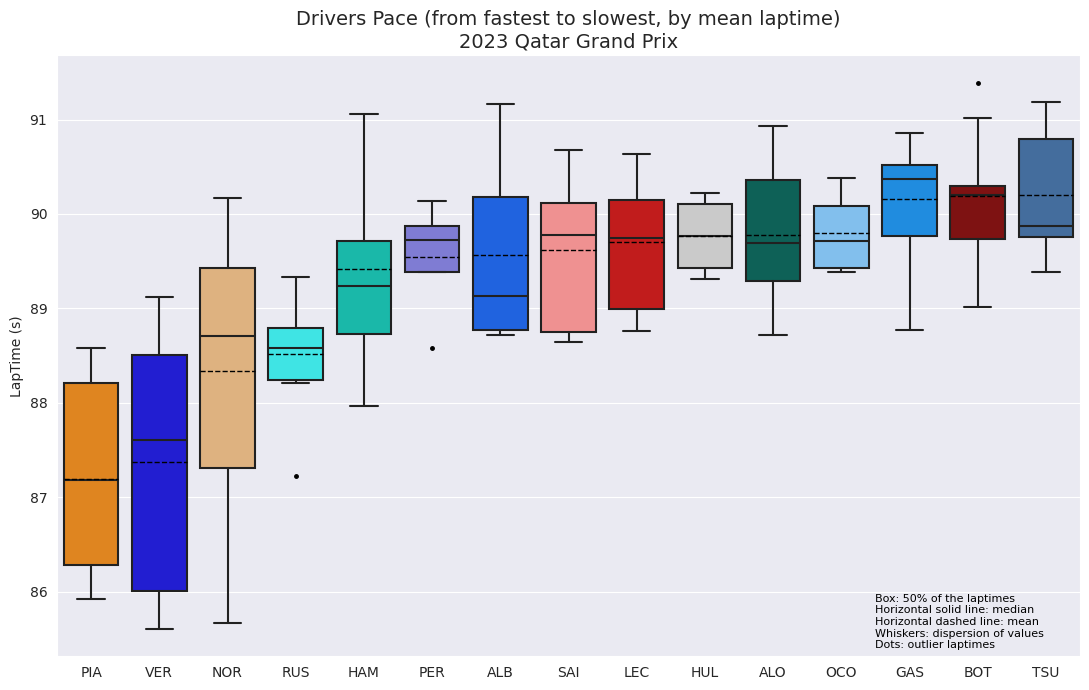

In [ ]:
# Scatter boxplot
fig, ax = plt.subplots(figsize=(11, 7))
plt.title(f"Drivers Pace (from fastest to slowest, by mean laptime)\n"
          f"{race.event.year} {race.event['EventName']}", size=14)

sns.boxplot(data=transformed_laps, x="Driver", y="LapTime (s)", showmeans=True, meanline=True, meanprops={'color': 'black'},
            order=driver_order[:18], palette=driver_palette, flierprops={"marker": ".", "markerfacecolor": "black", "markeredgecolor": "black"})
                            # [:] Change to plot just the ones with normal times
plt.text(0.80, 0.01,"Box: 50% of the laptimes\n"
                    "Horizontal solid line: median\n"
                    "Horizontal dashed line: mean\n"
                    "Whiskers: dispersion of values\n"
                    "Dots: outlier laptimes",
                    transform=ax.transAxes, fontsize=8, color='black', ha='left', va='bottom')

ax.set(xlabel=None)
plt.tight_layout()
#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/drivers_pace.png", bbox_inches='tight', bbox_inches='tight', dpi=500)
plt.show()

# Team Pace Comparison

In [ ]:
# Order the team from the fastest (lowest median lap time) to slower
team_order = (transformed_laps[["Team", "LapTime (s)"]].groupby("Team").mean()["LapTime (s)"].sort_values().index)

# Make a color palette associating team names to hex codes
team_palette = {team: ff1.plotting.team_color(team) for team in team_order}

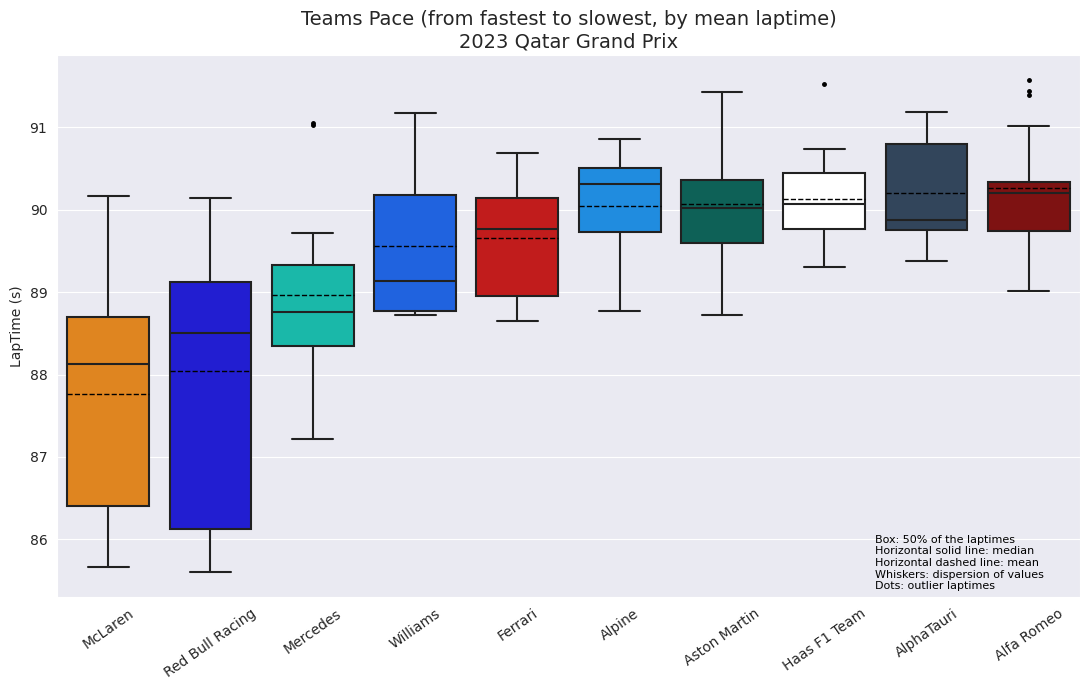

In [ ]:
# Scatter boxplot
fig, ax = plt.subplots(figsize=(11, 7))
plt.title(f"Teams Pace (from fastest to slowest, by mean laptime)\n"
          f"{race.event.year} {race.event['EventName']}", size=14)

sns.boxplot(data=transformed_laps, x="Team", y="LapTime (s)", showmeans=True, meanline=True, meanprops={'color': 'black'},
            order=team_order, palette=team_palette, flierprops={"marker": ".", "markerfacecolor": "black", "markeredgecolor": "black"})

plt.text(0.80, 0.01,"Box: 50% of the laptimes\n"
                    "Horizontal solid line: median\n"
                    "Horizontal dashed line: mean\n"
                    "Whiskers: dispersion of values\n"
                    "Dots: outlier laptimes",
                    transform=ax.transAxes, fontsize=8, color='black', ha='left', va='bottom')

ax.set(xlabel=None)
plt.xticks(rotation=35, ha='center')
plt.tight_layout()
#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/teams_pace.png", bbox_inches='tight', bbox_inches='tight', dpi=500)
plt.show()

# Track map with speed visualization and corners

In [ ]:
lap = race.laps.pick_fastest()
tel = lap.get_telemetry()
pos = lap.get_pos_data()    # Black line
circuit_info = race.get_circuit_info()

Plotting the track shape and the corners

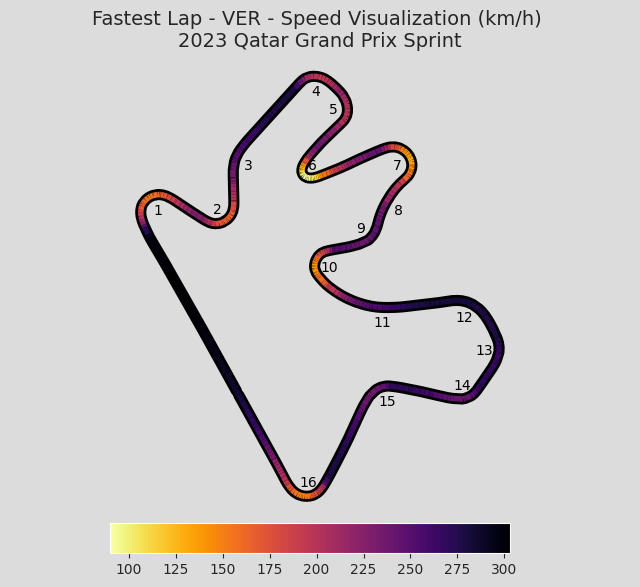

In [ ]:
        # For plotting the SPEED line:
# Where the car is at any moment in time ('x' n 'y' are columns in telemetry)
x = np.array(tel['X'].values)
y = np.array(tel['Y'].values)

# Now, we create a set of line segments so that we can color them individually
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
speed = tel['Speed'].to_numpy().astype(float)

# Create a line collection (coloring the shape track). Set a segmented colormap and normalize the plot to integer values of colormap
color = lap.telemetry['Speed']
colormap = mpl.cm.inferno.reversed()

lc = LineCollection(segments, norm=plt.Normalize(color.min(), color.max()), cmap=colormap, linewidth=4)
lc.set_array(speed)

        # For plotting the BLACK line:
# By matrix multiplication of the rotation matrix with a vector [x, y], a new rotated vector [x_rot, y_rot] is obtained.
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

    return np.matmul(xy, rot_mat)

# Get the coordinates: an array of shape [n, 2] where n is the number of points and the second axis is x and y
track = pos.loc[:, ('X', 'Y')].to_numpy()

'''=================================='''

# Create a figure
fig, ax = plt.subplots(figsize=(8, 6), facecolor='gainsboro')
plt.title(f"Fastest Lap - {lap['Driver']} - Speed Visualization (km/h) \n"
          f"{race.event.year} {race.event['EventName']} {race.name}", size=14)

# Add a solid black line around the circuit
plt.plot(track[:, 0], track[:, 1], color='black', linewidth=8)

# Add the LineCollection (speed lines) to the plot
ax.add_collection(lc)

# CORNERS
# 1-Length of the space between number and track
offset_vector = [500, 0]

# 2-Iterate over all corners
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Finally, PRINT THE CORNER NUMBER.
    plt.text(text_x, text_y, txt, va='center_baseline', ha='center', size='medium', color='black')

# Axes settings
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.axis('off')

# Finally, we create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap, orientation="horizontal")
#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/speed_track_race.png", bbox_inches='tight', bbox_inches='tight', dpi=500)
plt.show()

# Track map with gear shifts and corners

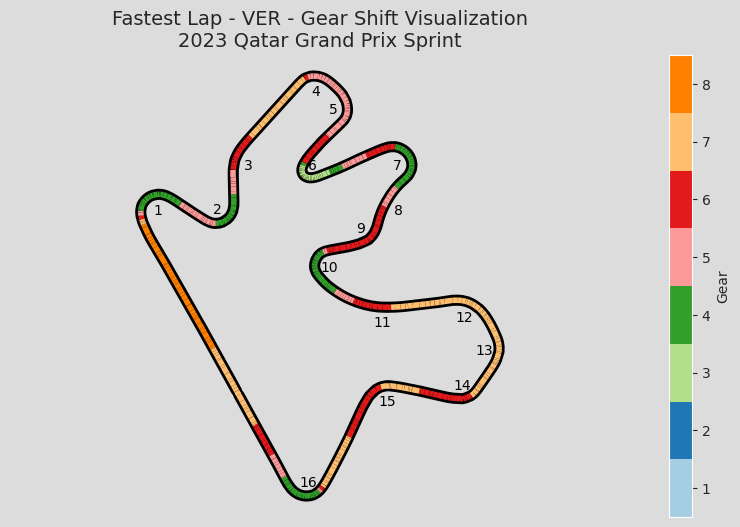

In [ ]:
# For plotting the GEAR line:
# Where the car is at any moment in time ('x' n 'y' are columns in telemetry)
x = np.array(tel['X'].values)
y = np.array(tel['Y'].values)

# Create points, and with them, segments (converting it to the appropriate numpy data types)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
gear = tel['nGear'].to_numpy().astype(float)

# Create a line collection (coloring the shape track). Set a segmented colormap and normalize the plot to integer values of colormap
colors = plt.get_cmap('Paired')
line_col = LineCollection(segments, norm=plt.Normalize(1, colors.N+1), cmap=colors, linewidth=4)
line_col.set_array(gear)

        # For plotting the BLACK line:
# By matrix multiplication of the rotation matrix with a vector [x, y], a new rotated vector [x_rot, y_rot] is obtained.
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

    return np.matmul(xy, rot_mat)

# Get the coordinates: an array of shape [n, 2] where n is the number of points and the second axis is x and y
track = pos.loc[:, ('X', 'Y')].to_numpy()

'''=================================='''

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6), facecolor='gainsboro')
plt.title(f"Fastest Lap - {lap['Driver']} - Gear Shift Visualization\n"
          f"{race.event.year} {race.event['EventName']} {race.name}", size=14)

# Add a solid black line around the circuit
plt.plot(track[:, 0], track[:, 1], color='black', linewidth=8)

# Add the collection of lines (gear lines) to represent the circuit
ax.add_collection(line_col)

# CORNERS
# 1-Length of the space between number and track
offset_vector = [500, 0]

# 2-Iterate over all corners
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Finally, PRINT THE CORNER NUMBER.
    plt.text(text_x, text_y, txt, va='center_baseline', ha='center', size='medium', color='black')

# Axes settings
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.axis('off')

# Add a colorbar to the plot. Change orientation depending on the track
lateral_bar = plt.colorbar(mappable=line_col, label="Gear", boundaries=np.arange(1, 10), orientation="vertical")   #or horizontal
lateral_bar.set_ticks(np.arange(1.5, 9.5))
lateral_bar.set_ticklabels(np.arange(1, 9))
#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/gear_track_race.png", bbox_inches='tight', dpi=500)
plt.show()

# Fastest Drivers in Each Sector

https://github.com/edmundhong/formula1-dataanalysis/blob/main/Race%20Analysis.ipynb

In [ ]:
# we pick only quick laps for this plot
df_quick = race.laps.pick_quicklaps()

# load dataframe of df_quick (by Final Position in ascending order)
df_quick = df_quick.sort_values(by=['LapNumber','Position'], ascending=[False, True]).reset_index(drop=True)

# fill in empty laptime records and convert to seconds
df_quick.LapTime = df_quick.LapTime.fillna(df_quick['Sector1Time']+df_quick['Sector2Time']+df_quick['Sector3Time'])
df_quick.LapTime = df_quick.LapTime.dt.total_seconds()
df_quick.Sector1Time = df_quick.Sector1Time.dt.total_seconds()
df_quick.Sector2Time = df_quick.Sector2Time.dt.total_seconds()
df_quick.Sector3Time = df_quick.Sector3Time.dt.total_seconds()

# Get the top 10 fastest average(mean) SectorTime
# use median to counter mixed conditions (exp: dry+wet)
top_10_sector1 = df_quick.groupby(['Driver'])['Sector1Time'].mean().sort_values().head(10).reset_index()
top_10_sector2 = df_quick.groupby(['Driver'])['Sector2Time'].mean().sort_values().head(10).reset_index()
top_10_sector3 = df_quick.groupby(['Driver'])['Sector3Time'].mean().sort_values().head(10).reset_index()

# for color palette
driver_color = {}
for index,lap in df_quick.iterrows():
    driver = lap['Driver']
    driver_color[driver] = ff1.plotting.driver_color(driver)

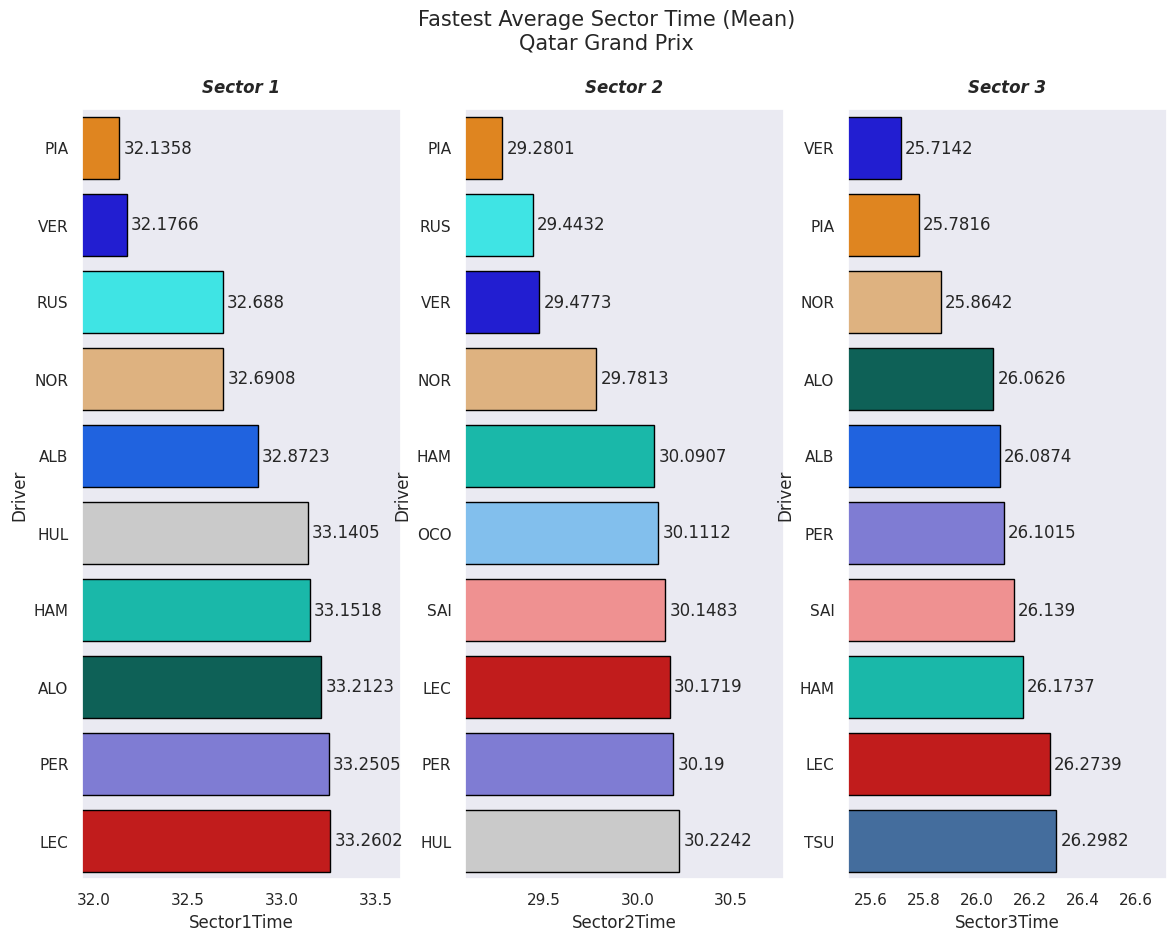

In [ ]:
# Plot
fig, ax = plt.subplots(1,3, figsize=(14, 10))
fig.suptitle('Fastest Average Sector Time (Mean)\n'+race.event.EventName, fontsize=15)

# Sector 1
sns.barplot(x=top_10_sector1['Sector1Time'], y=top_10_sector1['Driver'], palette=driver_color, ax=ax[0], edgecolor='black')
ax[0].set_title('Sector 1', fontweight="bold", fontstyle='italic')
ax[0].bar_label(ax[0].containers[0], padding=3)
ax[0].set_xlim(top_10_sector1.Sector1Time[0]-0.2,top_10_sector1.Sector1Time[0]+1.5)  # Cambiar segun diff, por estético

# Sector 2
sns.barplot(x=top_10_sector2['Sector2Time'], y=top_10_sector2['Driver'], palette=driver_color, ax=ax[1], edgecolor='black')
ax[1].set_title('Sector 2', fontweight="bold", fontstyle='italic')
ax[1].bar_label(ax[1].containers[0], padding=3)
ax[1].set_xlim(top_10_sector2.Sector2Time[0]-0.2,top_10_sector2.Sector2Time[0]+1.5)

# Sector 3
sns.barplot(x=top_10_sector3['Sector3Time'], y=top_10_sector3['Driver'], palette=driver_color, ax=ax[2], edgecolor='black')
ax[2].set_title('Sector 3', fontweight="bold", fontstyle='italic')
ax[2].bar_label(ax[2].containers[0], padding=3)
ax[2].set_xlim(top_10_sector3.Sector3Time[0]-0.2,top_10_sector3.Sector3Time[0]+1)

#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/fastest_sectors.png", bbox_inches='tight', dpi=500)
plt.show()

# Max and Min Speed of Each Team in Fastest Lap

In [ ]:
# Load again (if not, errors)
race.load()

# Load laps
df = race.laps

# Convert Times to seconds
df.LapTime = df.LapTime.dt.total_seconds()

In [ ]:
# Speeds
team_max_speed = {}
team_min_speed = {}

for team in set(df.Team):
    team_max_speed[team] = df.pick_team(team).pick_fastest().get_car_data().Speed.max()
    team_min_speed[team] = df.pick_team(team).pick_fastest().get_car_data().Speed.min()

team_max_speed = pd.DataFrame(team_max_speed.items(), columns=['Team', 'Max Speed']).sort_values('Max Speed', ascending=False).reset_index()
team_min_speed = pd.DataFrame(team_min_speed.items(), columns=['Team', 'Min Speed']).sort_values('Min Speed', ascending=False).reset_index()

team_color = {}
for team in team_max_speed.Team:
    team_color[team] = ff1.plotting.team_color(team)

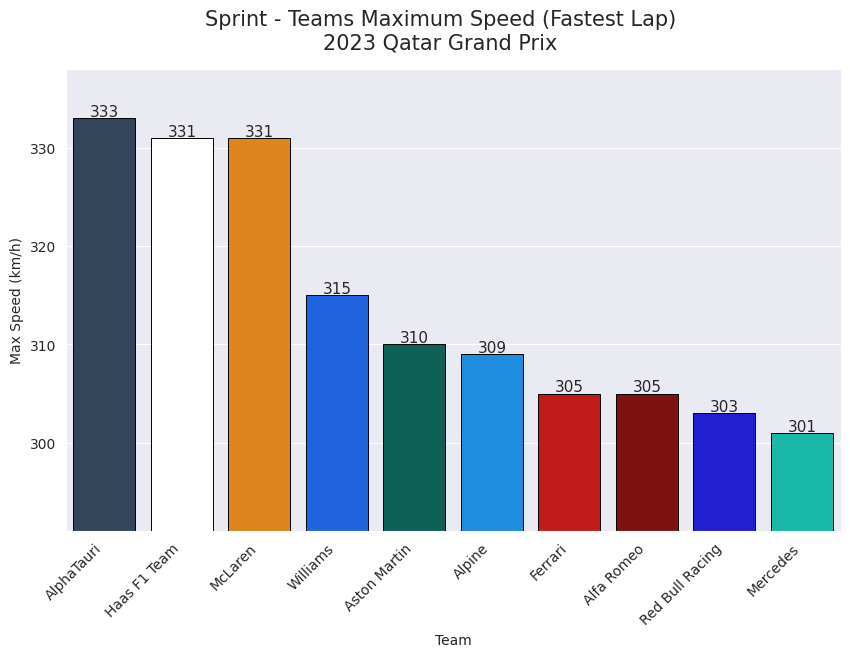

In [ ]:
# Plot max
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle(f"{race.name} - Teams Maximum Speed (Fastest Lap)\n{race.event.year} {race.event.EventName}", fontsize=15)

# Max Speed
sns.barplot(data=team_max_speed, x='Team', y='Max Speed' , palette=team_color, ax=ax, edgecolor='black', lw=0.7)
ax.set_ylim(team_max_speed['Max Speed'].min()-10, team_max_speed['Max Speed'].max()+5)    # Cambiar hasta que mole representación
plt.xticks(rotation=45, ha='right')

# Add speed
for i in range(len(team_max_speed)):
    ax.text(i, team_max_speed['Max Speed'][i]+0.2, team_max_speed['Max Speed'][i], ha = 'center', size = 11)

plt.ylabel('Max Speed (km/h)')
#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/max_speed.png", bbox_inches='tight', dpi=500)
plt.show()

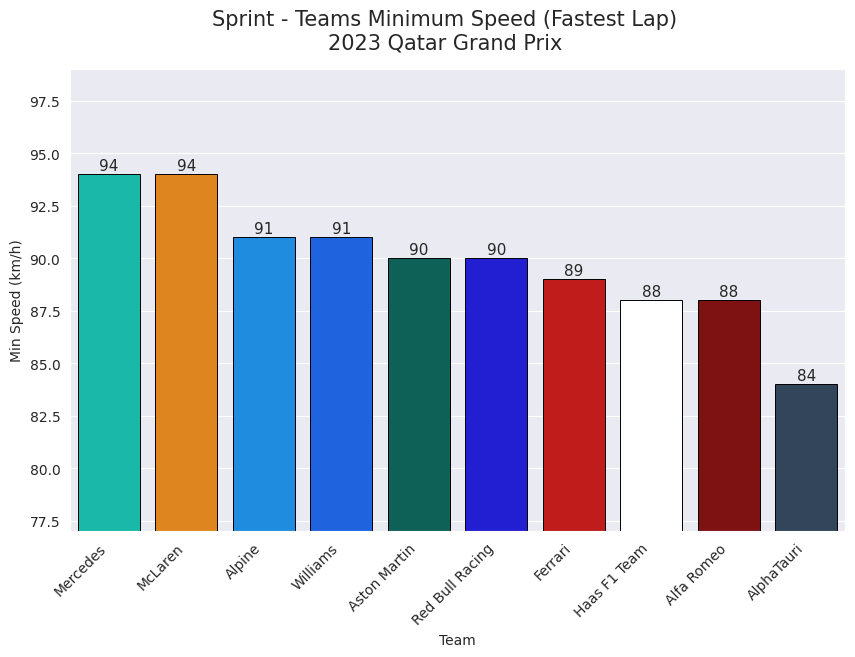

In [ ]:
# Plot min
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle(f"{race.name} - Teams Minimum Speed (Fastest Lap)\n{race.event.year} {race.event.EventName}", fontsize=15)

# Min Speed
sns.barplot(data=team_min_speed, x='Team', y='Min Speed' , palette=team_color, ax=ax, edgecolor='black', lw=0.7)
ax.set_ylim(team_min_speed['Min Speed'].min()-7, team_min_speed['Min Speed'].max()+5)
plt.xticks(rotation=45, ha='right')

# Add speed
for i in range(len(team_min_speed)):
    ax.text(i, team_min_speed['Min Speed'][i]+0.2, team_min_speed['Min Speed'][i], ha = 'center', size = 11)

plt.ylabel('Min Speed (km/h)')
#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/min_speed.png", bbox_inches='tight', dpi=500)
plt.show()

# Lap Time across Tyre Life (degradation)

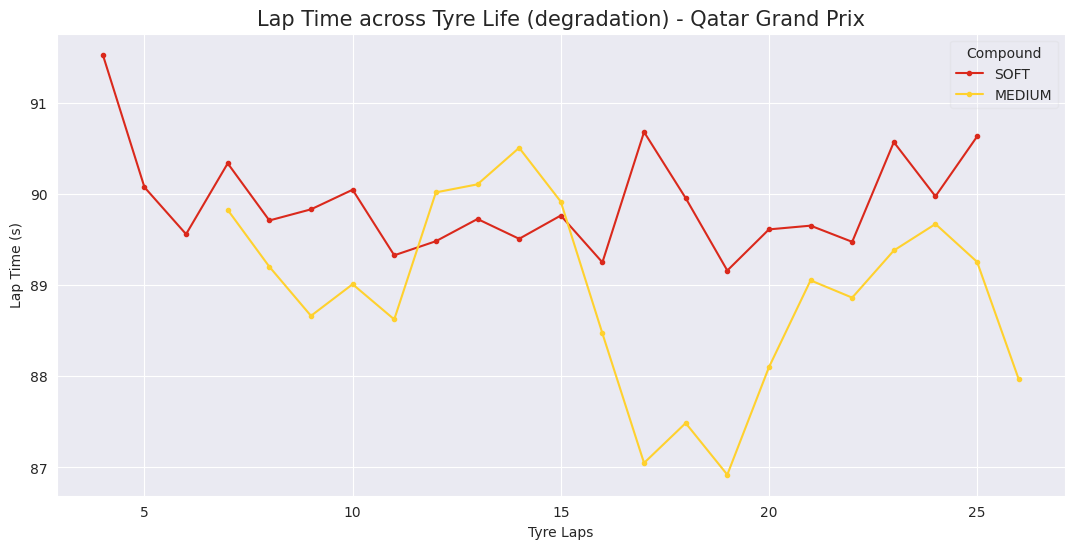

In [ ]:
# Problem: diff drivers with diff tyres, and diff laptimes, diff weights, so... not very representative
plt.figure(figsize=(13,6))
plt.title('Lap Time across Tyre Life (degradation) - '+race.event.EventName, fontsize=15)

for compound in set(df_quick.Compound):
    exec(f"average_laptime_per_tyrelife_{compound} = {{}}")
    data_tyre = df_quick.pick_tyre(compound)
    for tyrelife in range(1,int(data_tyre.TyreLife.max())+1):
        exec(f"average_laptime_per_tyrelife_{compound}[tyrelife] = data_tyre.loc[(df_quick['TyreLife'] == float(tyrelife)) & (df_quick['TrackStatus'] == '1'), ['LapTime']].mean()")
    exec(f"key = average_laptime_per_tyrelife_{compound}.keys()")
    exec(f"value = average_laptime_per_tyrelife_{compound}.values()")
    color = ''+ff1.plotting.COMPOUND_COLORS[compound] if compound != 'HARD' else "000000"
    plt.plot(key, value, color=color, marker='.', label=compound)

plt.ylabel('Lap Time (s)')
plt.xlabel('Tyre Laps')
plt.legend(title='Compound', framealpha=0.2)
#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/tyre_life.png", bbox_inches='tight', dpi=500)
plt.show()

# Tyre strategies during a race

In [ ]:
# Enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
ff1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

In [ ]:
# We want all, not just quick laps
laps = race.laps
drivers = race.drivers

# Drivers abbreviations
drivers = [race.get_driver(driver)["Abbreviation"] for driver in drivers]

# Stint length and compound used for every stint by every driver.
stints = laps[["Driver", "Stint", "Compound", "LapNumber", "FreshTyre"]]
stints = stints.groupby(["Driver", "Stint", "Compound", "FreshTyre"])
stints = stints.count().reset_index()

# The number in the LapNumber column now means the stint length.
stints = stints.rename(columns={"LapNumber": "StintLength"})

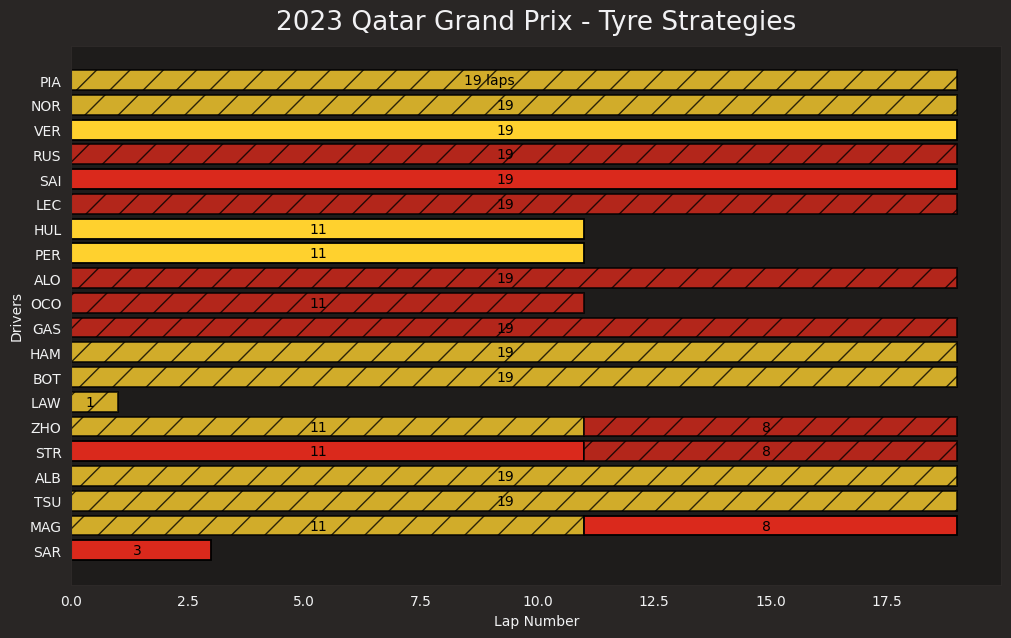

In [ ]:
# Now we can plot the strategies for each driver
fig, ax = plt.subplots(figsize=(12, 7))
plt.title(f"{race.event.year} {race.event.EventName} - Tyre Strategies")
sns.set(style="dark")

# Bars configuration
for i, driver in enumerate(drivers):
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        comp_color = ff1.plotting.COMPOUND_COLORS[row["Compound"]]
        plt.barh(y=i, width=row["StintLength"], left=previous_stint_end, color=comp_color, edgecolor="black", fill=True, linewidth=1.3,
                 alpha = 0.8 if not row.FreshTyre else 1, hatch = '/' if not row.FreshTyre else None)

        # Add 'laps' in first bar
        label = str(row["StintLength"])
        if i == 0:
            label = f"{label} laps"
        plt.text(previous_stint_end + row["StintLength"] / 2, i, label, ha='right', va='center', fontsize=10, color='black')
        previous_stint_end += row["StintLength"]

# Axes settings
plt.yticks(range(len(drivers)), drivers)
plt.xlabel("Lap Number")
plt.ylabel("Drivers")    # Hasta que no pasa un rato, no sale posición final
plt.grid(False)
ax.invert_yaxis()

#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/tyre_strategies.png", bbox_inches='tight', dpi=500)
plt.show()

# Drivers Laptimes Distribution (Violin) + Compound

In [ ]:
# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
ff1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

In [ ]:
# Get all the laps for the point finishers only and filter out slow laps
point_finishers = race.drivers[:10]
driver_laps = race.laps.pick_drivers(point_finishers).pick_quicklaps().reset_index()

# Get abbreviations in the finishing order.
finishing_order = [race.get_driver(i)["Abbreviation"] for i in point_finishers]

# We need to modify the palette. Its keys are the driver's full names but we need the keys to be the drivers'abbreviations.
driver_colors = {abv: ff1.plotting.DRIVER_COLORS[driver] for abv,
                 driver in ff1.plotting.DRIVER_TRANSLATE.items()}

AttributeError: ignored

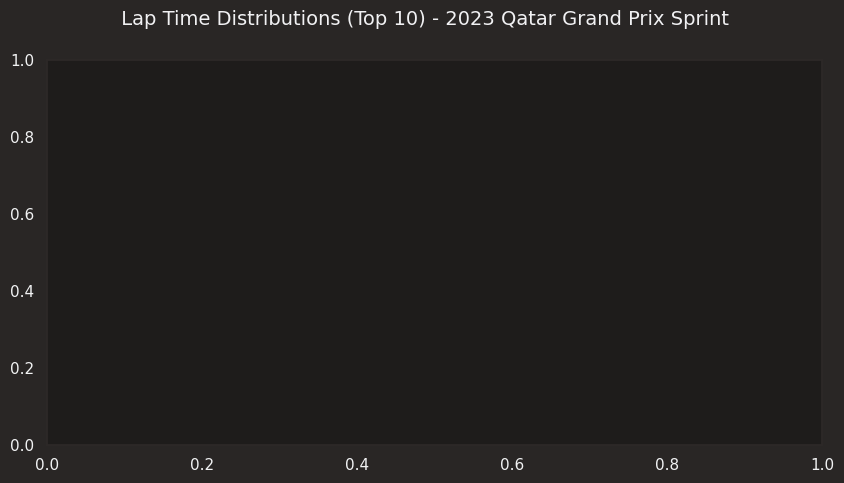

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.suptitle(f' Lap Time Distributions (Top 10) - {race.event.year} {race.event.EventName} {race.name}', size=14)

# Seaborn doesn't have proper timedelta support so we have to convert timedelta to float (in seconds)
driver_laps["LapTime(s)"] = driver_laps["LapTime"].dt.total_seconds()

# Violin plots to show the distributions
sns.violinplot(data=driver_laps, x="Driver", y="LapTime(s)", inner=None, scale="area", order=finishing_order, palette=driver_colors)

# Swarm plot to show the actual laptimes
sns.swarmplot(data=driver_laps, x="Driver", y="LapTime(s)", order=finishing_order, hue="Compound",
              palette=ff1.plotting.COMPOUND_COLORS, hue_order=["SOFT", "MEDIUM", "HARD"], linewidth=0.5, size=5)

ax.set_ylabel("LapTime (s)")
ax.set_xlabel("Driver (starting position)")
ax.legend(loc="lower right")
sns.despine(left=True, bottom=True)
plt.grid(False)
plt.tight_layout()
#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/laptimes_distribution_violin.png", bbox_inches='tight', dpi=500)
plt.show()

# Drivers Laptimes Scatterplot + Compound

In [ ]:
# The misc_mpl_mods option enables minor grid lines which clutter the plot
ff1.plotting.setup_mpl(misc_mpl_mods=True)

In [ ]:
# Get laps for a single driver and filter out slow laps as they distort the graph axis.
driver = 'VER'
driver_laps = race.laps.pick_driver(driver).pick_quicklaps().reset_index()

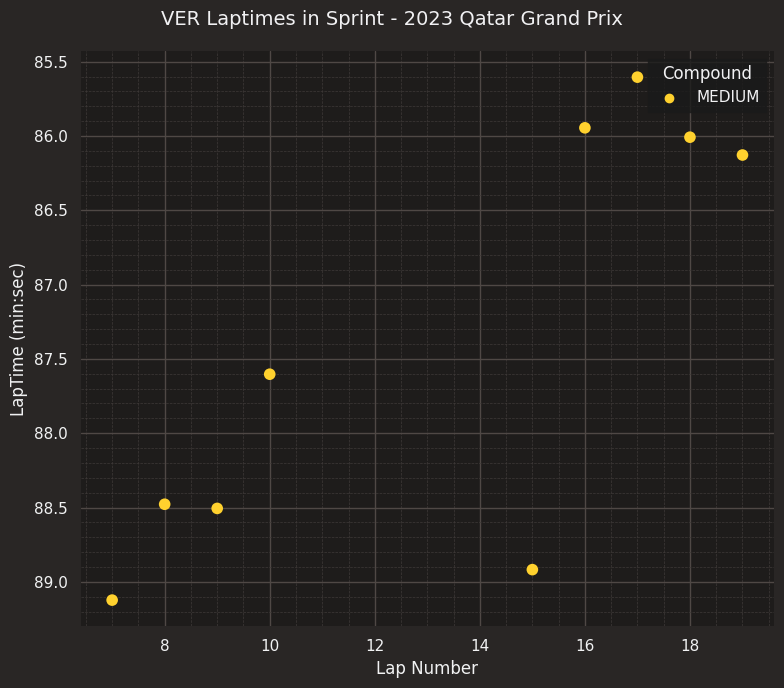

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(8, 7))
plt.suptitle(f'{driver} Laptimes in {race.name} - {race.event.year} {race.event.EventName}', size=14)

sns.scatterplot(data=driver_laps, x="LapNumber", y="LapTime", ax=ax, hue="Compound",
                palette=ff1.plotting.COMPOUND_COLORS, s=70, linewidth=0, legend='auto')

ax.set_xlabel("Lap Number")
ax.set_ylabel("LapTime (min:sec)")
ax.invert_yaxis()

sns.despine(left=True, bottom=True)

plt.tight_layout()
#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/laptimes_scatterplot.png", bbox_inches='tight', dpi=500)
plt.show()

Two drivers and differentiating compounds by colors

<ipython-input-38-4a91bffaabc7>:14: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(data=driver1_laps, x="LapNumber", y="LapTime", ax=ax, hue="Compound",
<ipython-input-38-4a91bffaabc7>:17: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(data=driver2_laps, x="LapNumber", y="LapTime", ax=ax, hue="Compound",


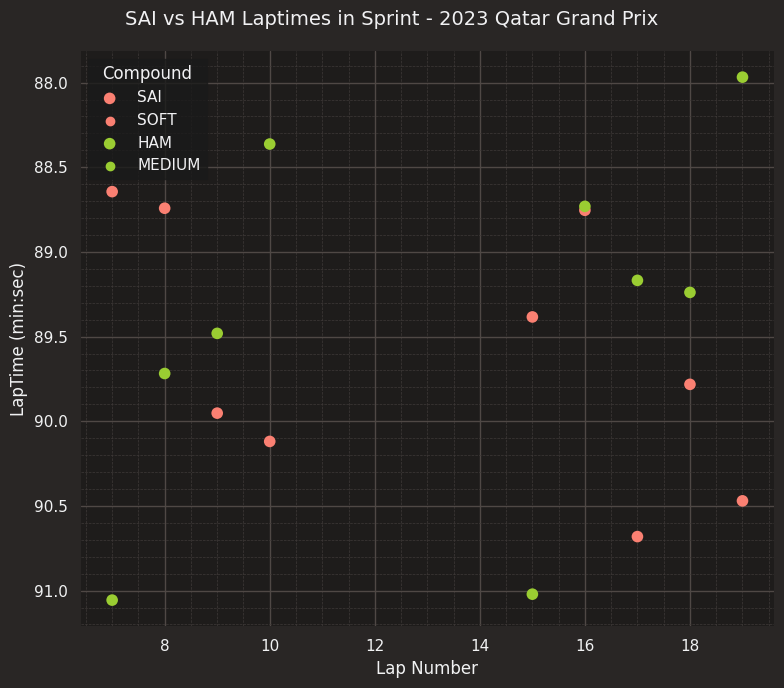

In [ ]:
# Driver info and colors
driver1 = 'SAI'
driver2 = 'HAM'
driver1_laps = race.laps.pick_driver(driver1).pick_quicklaps().reset_index()
driver2_laps = race.laps.pick_driver(driver2).pick_quicklaps().reset_index()
colors1 = ["salmon", "gainsboro"]  #M / H
colors2 = ["yellowgreen", "royalblue"]


# Plot
fig, ax = plt.subplots(figsize=(8, 7))
plt.suptitle(f'{driver1} vs {driver2} Laptimes in {race.name} - {race.event.year} {race.event.EventName}', size=14)

sns.scatterplot(data=driver1_laps, x="LapNumber", y="LapTime", ax=ax, hue="Compound",
                palette=colors1, s=70, linewidth=0, label=driver1)

sns.scatterplot(data=driver2_laps, x="LapNumber", y="LapTime", ax=ax, hue="Compound",
                palette=colors2, s=70, linewidth=0, label=driver2)

ax.set_xlabel("Lap Number")
ax.set_ylabel("LapTime (min:sec)")
ax.invert_yaxis()

sns.despine(left=True, bottom=True)

plt.tight_layout()
#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/laptimes_doble_scatterplot.png", bbox_inches='tight', dpi=500)
plt.show()

Podium drivers and no compound difference

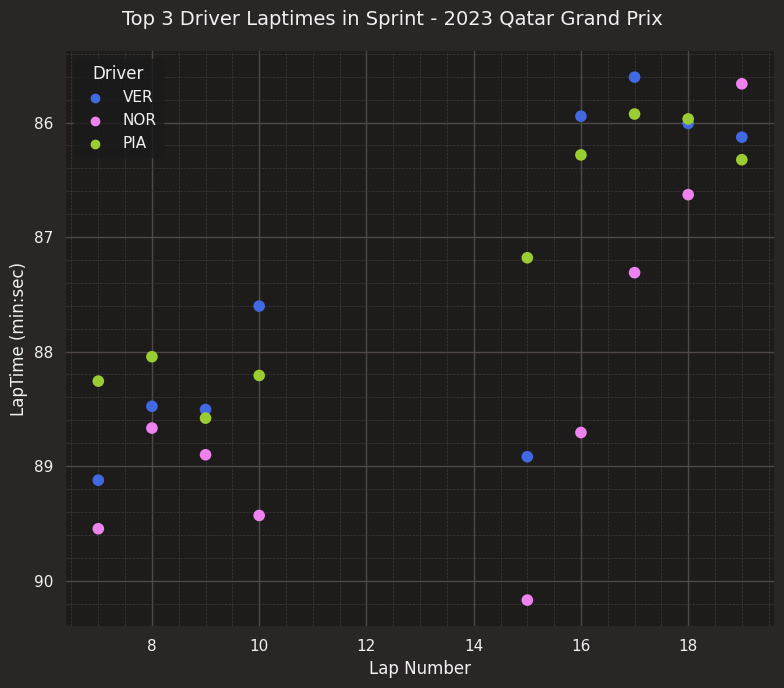

In [ ]:
# Get all the Top 3 drivers laps, filter out slow laps, colors.
point_finishers = race.drivers[:3]
driver_laps = race.laps.pick_drivers(point_finishers).pick_quicklaps().reset_index()
custom_colors = ["royalblue", "violet", "yellowgreen"]      # https://matplotlib.org/stable/gallery/color/named_colors.html


# Plot
fig, ax = plt.subplots(figsize=(8, 7))
plt.suptitle(f'Top 3 Driver Laptimes in {race.name} - {race.event.year} {race.event.EventName}', size=14)

sns.scatterplot(data=driver_laps, x="LapNumber", y="LapTime", ax=ax, hue="Driver",
                palette=custom_colors, s=70, linewidth=0, legend='auto')

ax.set_xlabel("Lap Number")
ax.set_ylabel("LapTime (min:sec)")
ax.invert_yaxis()

sns.despine(left=True, bottom=True)

plt.tight_layout()
#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/laptimes_triple_scatterplot.png", bbox_inches='tight', dpi=500)
plt.show()

# Lap time diff || Track Dominance (minisectors) || Telemetry (delta time)

### ***2º: Select the data***




In [ ]:
# Setup plotting (reset plot settings, now dark background)
plotting.setup_mpl()

# Load again (if not, errors)
session = race
session.load()

core           INFO 	Loading data for Qatar Grand Prix - Sprint [v3.1.2]
INFO:fastf1.fastf1.core:Loading data for Qatar Grand Prix - Sprint [v3.1.2]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 

In [ ]:
# Get the race laps
laps = session.laps

# Choose the drivers to be studied
driver1 = 'SAI'
driver2 = 'RUS'

# Select the laps from both drivers
laps_driver1 = laps.pick_driver(driver1)
laps_driver2 = laps.pick_driver(driver2)

# Select the fastest lap
fastest_driver1 = laps_driver1.pick_fastest()
fastest_driver2 = laps_driver2.pick_fastest()

# Get fastest quali lap telemetry (.get_car_data doesn't work, we need the 'X' and 'Y' columns from .get_telemetry)
fastest_lap_driver1 = fastest_driver1.get_telemetry().add_distance()
fastest_lap_driver2 = fastest_driver2.get_telemetry().add_distance()

# New column that indicates the driver
fastest_lap_driver1['Driver'] = driver1
fastest_lap_driver2['Driver'] = driver2

# Merge both lap telemetries
telemetry = fastest_lap_driver1.append(fastest_lap_driver2)

<ipython-input-41-e37d79634727>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = fastest_lap_driver1.append(fastest_lap_driver2)


### **Some information about the race:**

In [ ]:
# Fastest lap of each driver
print(f"Fastest lap of {driver1}: {fastest_driver1['LapTime']}")
print(f"Fastest lap of {driver2}: {fastest_driver2['LapTime']}")

Fastest lap of SAI: 0 days 00:01:28.644000
Fastest lap of RUS: 0 days 00:01:27.220000


In [ ]:
# Info about the fastest race lap
fastest_lap = laps.pick_fastest()

print('Fastest lap: ', fastest_lap['LapTime'])
print('Fastest lap on lap number', fastest_lap['LapNumber'])
print(f"Tyre compound: {fastest_lap['Compound']}, with {fastest_lap['TyreLife']} laps of use")
print('Driver: ', fastest_lap['Driver'])

Fastest lap:  0 days 00:01:25.604000
Fastest lap on lap number 17.0
Tyre compound: MEDIUM, with 17.0 laps of use
Driver:  VER


In [ ]:
# Fastest sectors
df = pd.DataFrame(laps)

# Look for the minimum value of that column
min_sector1 = df['Sector1Time'].idxmin()
min_sector2 = df['Sector2Time'].idxmin()
min_sector3 = df['Sector3Time'].idxmin()

# Info about the row containing the minimum value
sector1_data = df.loc[min_sector1]
sector2_data = df.loc[min_sector2]
sector3_data = df.loc[min_sector3]

print(f"The fastest Sector 1 is {sector1_data['Sector1Time']} seconds, driver: {sector1_data['Driver']}.")
print(f"The fastest Sector 2 is {sector2_data['Sector2Time']} seconds, driver: {sector2_data['Driver']}.")
print(f"The fastest Sector 3 is {sector3_data['Sector3Time']} seconds, driver: {sector3_data['Driver']}.")

The fastest Sector 1 is 0 days 00:00:31.283000 seconds, driver: NOR.
The fastest Sector 2 is 0 days 00:00:28.855000 seconds, driver: VER.
The fastest Sector 3 is 0 days 00:00:25.089000 seconds, driver: VER.


### ***Plot: Lap times during the race***

In [ ]:
driver1_color = ff1.plotting.driver_color(driver1)
driver2_color = ff1.plotting.driver_color(driver2)

# We remove slow laps to avoid distorting the results
quicks_laps_driver1 = laps.pick_driver(driver1).pick_quicklaps()
quicks_laps_driver2 = laps.pick_driver(driver2).pick_quicklaps()

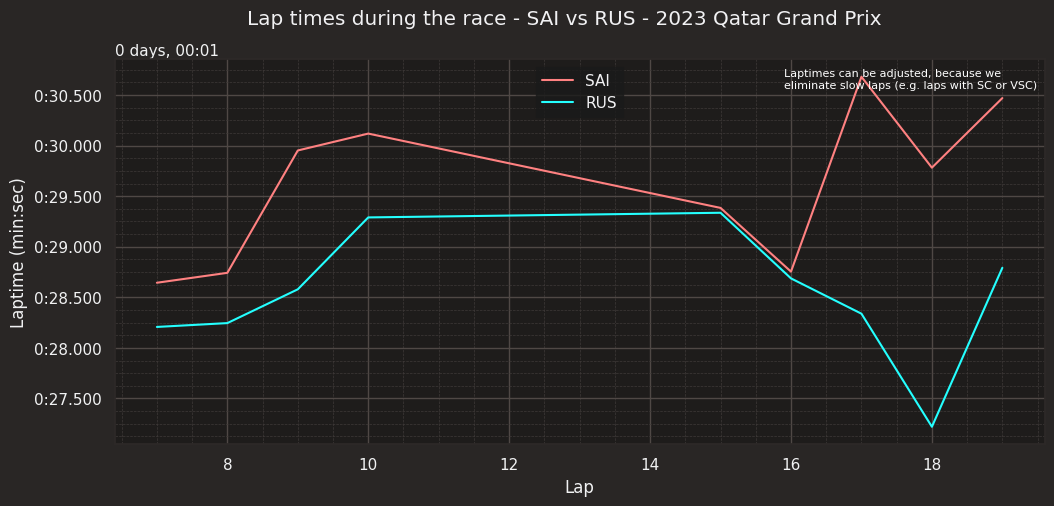

In [ ]:
# Lap time analysis of both drivers during the race
fig, ax = plt.subplots(figsize=(12,5))

fig.suptitle(f"Lap times during the race - {driver1} vs {driver2} - {session.event.year} {session.event.EventName}")

ax.plot(quicks_laps_driver1['LapNumber'], quicks_laps_driver1['LapTime'], label=driver1, color=driver1_color)
ax.plot(quicks_laps_driver2['LapNumber'], quicks_laps_driver2['LapTime'], label=driver2, color=driver2_color)

plt.text(0.72, 0.92, "Laptimes can be adjusted, because we \neliminate slow laps (e.g. laps with SC or VSC)",
         transform=ax.transAxes, fontsize=8, color='white', ha='left', va='bottom')

ax.set(ylabel='Laptime (min:sec)', xlabel='Lap')
ax.legend(loc="upper center")

#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/race_laptimes.png", bbox_inches='tight', dpi=500)

plt.show()

### ***Plot: Minisectors dominance***

Revisar, pq creo que coge las dos vueltas mas rapidas, no coincidentes. Para comparar pelea por vuelta rápida vale, pero una vuelta de un adelantamiento no, por ej

In [ ]:
# Number of minisectors of equal size (you can change it)
num_minisectors = 25

# Track distance
total_distance = max(telemetry['Distance'])

# Generate =sized minisectors
minisector_length = total_distance / num_minisectors

# Create a minisector column (assign every row a minisector depending on the current distance) - then we merge based on this column
telemetry['Minisector'] = (telemetry['Distance'] // minisector_length + 1)

# New DF: we calculate avg. speed per driver per minisector
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

# Select the driver with the highest average speed (.loc extracts the rows)
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Delete speed column and rename the driver one
fastest_driver = fastest_driver[['Minisector', 'Driver']]
fastest_driver = fastest_driver.rename(columns={'Driver': 'Fastest_driver'})

# Combine 2 DF: telemetry (main) with fastest_driver per minisector (based on minisector column, every minisector repeated, = driver)
telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance
telemetry = telemetry.sort_values(by=['Distance'])

# New column: convert driver name to integer (if fastest = VER -> 1)
telemetry.loc[telemetry['Fastest_driver'] == driver1, 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == driver2, 'Fastest_driver_int'] = 2

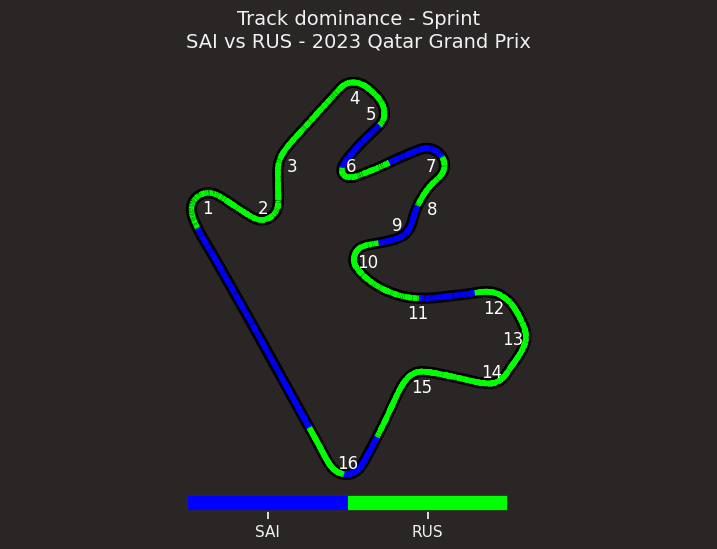

In [ ]:
        # For plotting the DOMINANCE line:
# Where the car is at any moment in time ('x' n 'y' are columns in telemetry)
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

# Create points, and with them, segments (converting it to the appropriate numpy data types)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

# Coloring the plot (more colors: https://matplotlib.org/stable/tutorials/colors/colormaps.html)
colors = plt.get_cmap('brg', 2)
line_col = LineCollection(segments, norm=plt.Normalize(1, colors.N+1), cmap=colors, linewidth=4)   # line coordinates| map value-colors | colors
line_col.set_array(fastest_driver_array)                                                           # plot colors according to the fastest driver

        # For plotting the BLACK line:
laps = session.laps.pick_fastest()
pos = laps.get_pos_data()
circuit_info = session.get_circuit_info()

# By matrix multiplication of the rotation matrix with a vector [x, y], a new rotated vector [x_rot, y_rot] is obtained.
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

    return np.matmul(xy, rot_mat)

# Get the coordinates: an array of shape [n, 2] where n is the number of points and the second axis is x and y
track = pos.loc[:, ('X', 'Y')].to_numpy()

'''=================================='''

# Create the plot (circuit shape)
plt.figure(figsize=(9, 8))
plt.title(f'Track dominance - {session.name}\n'
          f'{driver1} vs {driver2} - {session.event.year} {session.event.EventName}', size=14)

# Add a solid black line around the circuit
plt.plot(track[:, 0], track[:, 1], color='black', linewidth=8)

# Add the collection of lines (dominance) to represent the circuit
plt.gca().add_collection(line_col)

# CORNERS
# 1-Length of the space between number and track
offset_vector = [500, 0]

# 2-Iterate over all corners
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Finally, PRINT THE CORNER NUMBER.
    plt.text(text_x, text_y, txt, va='center_baseline', ha='center', size='medium', color='white')

# Axes settings
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.axis('off')

# Add a lateral colorbar to the plot (legend)
lateral_bar = plt.colorbar(mappable=line_col, boundaries=np.arange(1,4), shrink=0.6, orientation='horizontal')   # data origin (fastest driver) | legend limits
lateral_bar.ax.set_position([0.2, 0.32, 0.6, 0.02])  # [left, bottom, width, height]
lateral_bar.set_ticks(np.arange(1.5, 3.5))                                        # where the driver-marks are
lateral_bar.set_ticklabels([driver1, driver2])

#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/minisector_doble_dominance.png", bbox_inches='tight', dpi=500)

plt.show()

### ***Plot: Telemetry***

**Time delta**

Use with caution: this delta is an estimation, and not too accurate. So, it doesn't represent the real gap during the whole lap, but it shows us where a driver gained or lost time compared to another (plotted together with 'speed').

In [ ]:
delta_time, ref_tel, compare_tel = utils.delta_time(fastest_driver1, fastest_driver2)

/usr/local/lib/python3.10/dist-packages/fastf1/utils.py:86: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"


In [ ]:
# RACE: Get lap XX telemetry data
lap_analyze = 50
lap_telemetry_driver1 = laps_driver1.loc[laps_driver1['LapNumber']==lap_analyze].get_car_data().add_distance()
lap_telemetry_driver2 = laps_driver2.loc[laps_driver2['LapNumber']==lap_analyze].get_car_data().add_distance()

ValueError: ignored

In [ ]:
driver1_color = ff1.plotting.driver_color(driver1)
driver2_color = ff1.plotting.driver_color(driver2)

In [ ]:
# Create the plot
fig, ax = plt.subplots(5, figsize=(14,15), gridspec_kw={'height_ratios': [2, 0.8, 1, 0.8, 0.8]})

ax[0].title.set_text(f"Lap {lap_analyze} Telemetry, {driver1} vs {driver2} - {session.event.year} {session.event.EventName}\n")   # Here in [0], to be closer to the plot

# Speed
ax[0].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Speed'], label=driver1, color=driver1_color)
ax[0].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Speed'], label=driver2, color=driver2_color)
ax[0].set_ylabel('Speed (km/h)', fontsize=13)
ax[0].legend(loc="upper center")

# Delta
twin = ax[0].twinx()   # right scale
twin.plot(ref_tel['Distance'], delta_time, '--', color='white')
twin.set_ylabel(f"<-- {driver2} ahead | {driver1} ahead (s)-->", size=15)

# Maximum and Minimum speed of drivers
driver1_max_speed = lap_telemetry_driver1['Speed'].max()
driver1_min_speed = lap_telemetry_driver1['Speed'].min()
driver2_max_speed = lap_telemetry_driver2['Speed'].max()
driver2_min_speed = lap_telemetry_driver2['Speed'].min()
ax[0].annotate(f'{driver1}: {driver1_max_speed} km/h', (lap_telemetry_driver1['Distance'][lap_telemetry_driver1['Speed'].idxmax()], driver1_max_speed), textcoords="offset points", xytext=(0, 0), ha='left', color='white')   #valores x,y | posición texto
ax[0].annotate(f'{driver1}: {driver1_min_speed} km/h', (lap_telemetry_driver1['Distance'][lap_telemetry_driver1['Speed'].idxmin()], driver1_min_speed), textcoords="offset points", xytext=(0, 0), ha='left', color='white')
ax[0].annotate(f'{driver2}: {driver2_max_speed} km/h', (lap_telemetry_driver2['Distance'][lap_telemetry_driver2['Speed'].idxmax()], driver2_max_speed), textcoords="offset points", xytext=(0, 10), ha='left', color='white')
ax[0].annotate(f'{driver2}: {driver2_min_speed} km/h', (lap_telemetry_driver2['Distance'][lap_telemetry_driver2['Speed'].idxmin()], driver2_min_speed), textcoords="offset points", xytext=(0, -10), ha='left', color='white')

# Gear
ax[1].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['nGear'], label=driver1, color=driver1_color)
ax[1].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['nGear'], label=driver2, color=driver2_color)
ax[1].set_ylabel('Gear', fontsize=13)

# Throttle
ax[2].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Throttle'], label=driver1, color=driver1_color)
ax[2].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Throttle'], label=driver2, color=driver2_color)
ax[2].set_ylabel('Throttle (%)', fontsize=13)

# Brake
ax[3].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Brake'], label=driver1, color=driver1_color)
ax[3].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Brake'], label=driver2, color=driver2_color)
ax[3].set_ylabel('Off - Brakes - On', fontsize=13)

# DRS
ax[4].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['DRS'], label=driver1, color=driver1_color)
ax[4].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['DRS'], label=driver2, color=driver2_color)
ax[4].set_ylabel('Off - DRS - On', fontsize=13)
ax[4].set(xlabel='Lap distance (m)')

# Hide axis labels on subplots that are not on the outer edges
for a in ax.flat:
    a.label_outer()

# No space in the sides
for i in range(5):
    ax[i].set_xlim(0, max(lap_telemetry_driver1['Distance']))

#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/full_telemetry.png", bbox_inches='tight', dpi=500)

plt.show()

# Lap time diff (stint n mean) || Telemetry (distance n delta)
Difference: analyze with 'driver ahead'

### ***2º: Select the data***

In [ ]:
laps = session.laps

# Here we change the drivers, we need 2 that were together in race (and in the 'stint' if we code it)
driver1 = 'SAI'
driver2 = 'LEC'

# Get the laps info of the drivers (delete slow laps)
laps_driver1 = laps.pick_driver(driver1).pick_quicklaps()
laps_driver2 = laps.pick_driver(driver2).pick_quicklaps()

# Optional, or change stint... depends, but keep in mind that we need 2 drivers that were together in race
# If we only want to analyze stint 1 (until first pitstop) - pitstop can distort plots
laps_driver1 = laps_driver1.loc[laps_driver1['Stint'] == 1]
laps_driver2 = laps_driver2.loc[laps_driver2['Stint'] == 1]

# Create a DataFrame of all the distances between 2 drivers at any moment during any lap (comparing lap by lap)
full_distance_driver1_driver2 = pd.DataFrame()

# DF of the average distance per lap
average_distance_driver1_driver2 = pd.DataFrame()

In [ ]:
# Iterate the rows (laps) of a DataFrame in a loop, providing access to each row one by one
for lap in laps_driver2.iterlaps():
    telemetry = lap[1].get_car_data().add_distance().add_driver_ahead()     # 1-load telemetry /2-add column of m driven /3-add col of driver_ahead y distance_...

    # This loop only runs when driver1 (SAI) is ahead, and driver2 (LEC) right behind (just this fight); otherwise we compare wrong distance gaps
    telemetry = telemetry.loc[telemetry['DriverAhead'] == "55"]

    if len(telemetry) != 0:    # Check that the box is not empty. If it is, 1st is no longer in front of it and is no longer of interest.
        lap_telemetry = telemetry[['Distance', 'DistanceToDriverAhead']]    # Select the columns we want to know (the two added before)
        lap_telemetry.loc[:, 'Lap'] = lap[0] -247   # (248-247)             # ** We subtract the necessary laps to start at 1 (Problem: Laps don't start at 1 and data is not displayed)

        full_distance_driver1_driver2 = full_distance_driver1_driver2.append(lap_telemetry)   # Add lap_telemetry rows to the dataframe

        # Average / median distance (ignore NaN values, ex: pitstops)
        distance_mean = np.nanmean(telemetry['DistanceToDriverAhead'])
        distance_median = np.nanmedian(telemetry['DistanceToDriverAhead'])

        # New columns to the dataframe: distances between pilots at a specific moment in time
        average_distance_driver1_driver2 = average_distance_driver1_driver2.append({
            'Lap': lap[0] -247,   # ** We subtract the necessary laps to start at 1 (Problem: Laps don't start at 1 and data is not displayed)
            'Mean': distance_mean,
            'Median': distance_median},
            ignore_index = True)

### ***Plot: Lap time diff***

In [ ]:
driver1_color = ff1.plotting.driver_color(driver1)
driver2_color = ff1.plotting.driver_color(driver2)

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
fig.suptitle(f"{driver1} vs {driver2} opening stint comparison (Laptimes)")

# Lap times (minutes) during the opening stint
ax.plot(laps_driver1['LapNumber'], laps_driver1['LapTime'], label=driver1, color=driver1_color)
ax.plot(laps_driver2['LapNumber'], laps_driver2['LapTime'], label=driver2, color=driver2_color)

plt.text(0.66, 0.92, "Laptimes can be adjusted, because we \neliminate slow laps (e.g. laps with SC or VSC)",
         transform=ax.transAxes, fontsize=8, color='white', ha='left', va='bottom')

plt.xticks(np.arange(0, laps_driver1['LapNumber'].count() + 1, step=2))   #or laps_driver1['LapNumber'].min() when u don't start lap 1
ax.set(ylabel='Laptime (min:sec)', xlabel='Lap')
ax.legend(loc="upper center")

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
fig.suptitle(f"{driver1} vs {driver2} (Average distance)")

# Average distance (meters) between both drivers (just plot when they are together in race: 1-2, 4-5, 8-9...).
ax.plot(average_distance_driver1_driver2['Lap'], average_distance_driver1_driver2['Mean'], label='Mean')
ax.plot(average_distance_driver1_driver2['Lap'], average_distance_driver1_driver2['Median'], label='Median')

plt.text(0.02, 0.92, f"This plot only represents the distance for the {average_distance_driver1_driver2['Lap'].count()} laps\n"
                     f"in which {driver1} was ahead of {driver2} by only 1 position",
         transform=ax.transAxes, fontsize=8, color='white', ha='left', va='bottom')

plt.xticks(np.arange(0, average_distance_driver1_driver2['Lap'].count() + 1, step=2))   # or laps_driver1['LapNumber'].min() when u don't start lap 1
ax.set(ylabel=f"Distance {driver1} to {driver2} (m)", xlabel='Lap')
ax.legend(loc="upper center")

plt.show()

### ***Plot: Telemetry***

In [ ]:
# Get lap data (telemetry plots lap 15)
lap_analyze2 = 15
lap_telemetry_driver1 = laps_driver1.loc[laps_driver1['LapNumber']==lap_analyze2].get_car_data().add_distance()
lap_telemetry_driver2 = laps_driver2.loc[laps_driver2['LapNumber']==lap_analyze2].get_car_data().add_distance()

# Just to see distance between drivers
distance_lap12 = full_distance_driver1_driver2.loc[full_distance_driver1_driver2['Lap']==12]
distance_lap13 = full_distance_driver1_driver2.loc[full_distance_driver1_driver2['Lap']==13]
distance_lap14 = full_distance_driver1_driver2.loc[full_distance_driver1_driver2['Lap']==14]
distance_lap15 = full_distance_driver1_driver2.loc[full_distance_driver1_driver2['Lap']==15]

In [ ]:
fig, ax = plt.subplots(6, figsize=(14,15), gridspec_kw={'height_ratios': [1.5, 2, 0.8, 1, 0.8, 0.8]})

ax[0].title.set_text(f"Lap {lap_analyze2} Telemetry, {driver1} vs {driver2} - {session.event.year} {session.event.EventName}\n")

# Distance (m)
ax[0].plot(distance_lap12['Distance'], distance_lap12['DistanceToDriverAhead'], label='Lap 12', linestyle='dashed', color='grey')
ax[0].plot(distance_lap13['Distance'], distance_lap13['DistanceToDriverAhead'], label='Lap 13', linestyle='dashdot', color='lightgrey')
ax[0].plot(distance_lap14['Distance'], distance_lap14['DistanceToDriverAhead'], label='Lap 14', linestyle='dotted', color='white')
ax[0].plot(distance_lap15['Distance'], distance_lap15['DistanceToDriverAhead'], label='Lap 15', color=driver1_color)
ax[0].set_ylabel(f'Distance to {driver1} (m)', fontsize=13)
ax[0].legend(loc="lower right")

# Speed
ax[1].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Speed'], label=driver1, color=driver1_color)
ax[1].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Speed'], label=driver2, color=driver2_color)
ax[1].set_ylabel('Speed (km/h)', fontsize=13)
ax[1].legend(loc="upper center")

# Delta
twin = ax[1].twinx()   # right scale
twin.plot(ref_tel['Distance'], delta_time, '--', color='white')
twin.set_ylabel(f"<-- {driver2} ahead | {driver1} ahead -->", size=15)

# Maximum and Minimum speed of drivers
driver1_max_speed = lap_telemetry_driver1['Speed'].max()
driver1_min_speed = lap_telemetry_driver1['Speed'].min()
driver2_max_speed = lap_telemetry_driver2['Speed'].max()
driver2_min_speed = lap_telemetry_driver2['Speed'].min()
ax[1].annotate(f'{driver1}: {driver1_max_speed} km/h', (lap_telemetry_driver1['Distance'][lap_telemetry_driver1['Speed'].idxmax()], driver1_max_speed), textcoords="offset points", xytext=(0, 0), ha='left', color='white')   #valores x,y | posición texto
ax[1].annotate(f'{driver1}: {driver1_min_speed} km/h', (lap_telemetry_driver1['Distance'][lap_telemetry_driver1['Speed'].idxmin()], driver1_min_speed), textcoords="offset points", xytext=(0, 0), ha='left', color='white')
ax[1].annotate(f'{driver2}: {driver2_max_speed} km/h', (lap_telemetry_driver2['Distance'][lap_telemetry_driver2['Speed'].idxmax()], driver2_max_speed), textcoords="offset points", xytext=(0, 5), ha='left', color='white')
ax[1].annotate(f'{driver2}: {driver2_min_speed} km/h', (lap_telemetry_driver2['Distance'][lap_telemetry_driver2['Speed'].idxmin()], driver2_min_speed), textcoords="offset points", xytext=(0, -10), ha='left', color='white')

# Gear
ax[2].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['nGear'], label=driver1, color=driver1_color)
ax[2].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['nGear'], label=driver2, color=driver2_color)
ax[2].set_ylabel('Gear', fontsize=13)

# Throttle
ax[3].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Throttle'], label=driver1, color=driver1_color)
ax[3].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Throttle'], label=driver2, color=driver2_color)
ax[3].set_ylabel('Throttle (%)', fontsize=13)

# Brake
ax[4].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['Brake'], label=driver1, color=driver1_color)
ax[4].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['Brake'], label=driver2, color=driver2_color)
ax[4].set_ylabel('Off - Brakes - On', fontsize=13)

# DRS
ax[5].plot(lap_telemetry_driver1['Distance'], lap_telemetry_driver1['DRS'], label=driver1, color=driver1_color)
ax[5].plot(lap_telemetry_driver2['Distance'], lap_telemetry_driver2['DRS'], label=driver2, color=driver2_color)
ax[5].set_ylabel('Off - DRS - On', fontsize=13)
ax[5].set(xlabel='Lap distance (m)')

# Hide axis labels on subplots that are not on the outer edges
for a in ax.flat:
    a.label_outer()

# No space in the sides
for i in range(5):
    ax[i].set_xlim(0, max(lap_telemetry_driver1['Distance']))

#plt.savefig(f"/content/drive/MyDrive/F1/17.Qatar_(Losail)_23/Fotos/full_telemetry.png", bbox_inches='tight', dpi=500)

plt.show()